In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from langchain.globals import set_verbose, set_debug

set_debug(False)
set_verbose(False)

In [3]:
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.vectorstores import Chroma
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.retrievers.document_compressors import LLMChainFilter
from langchain.retrievers import ContextualCompressionRetriever
from langchain_core.messages import AIMessage, HumanMessage

In [4]:
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# RAG

In [5]:
persist_directory = 'all_docs_zotero/chroma/'
embedding = OpenAIEmbeddings()

vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

In [6]:
metadata_field_info = [
    AttributeInfo(
        name="Publication Year",
        description="The year that the paper was published.",
        type="integer",
    ),
    AttributeInfo(
        name="Date Added",
        description="The year that the paper was added to the collection.",
        type="integer",
    ),
    AttributeInfo(
        name="Author",
        description="Authors of the paper, it could be couple of people.",
        type="string",
    ),
    AttributeInfo(
        name="Title", 
        description="Title of the paper that the paper is about.", 
        type="string",
    ),
]

document_content_description = "Brain Heart Interconnectome (BHI) research papers"

retriever = SelfQueryRetriever.from_llm(
    llm,
    vectordb,
    document_content_description,
    metadata_field_info,
    #search_kwargs={"k": 10}
    #enable_limit=True,
)

_filter = LLMChainFilter.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=_filter,
    base_retriever=retriever
)

In [7]:
### Contextualize question ###
contextualize_q_system_prompt = """Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question \
which can be understood without the chat history. Do NOT answer the question, \
just reformulate it if needed and otherwise return it as is."""

contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, compression_retriever, contextualize_q_prompt
)

### Answer question ###
qa_system_prompt = """You are an assistant for question-answering tasks. \
Use the following pieces of retrieved context to answer the question. \
If you don't know the answer, just say that you don't know.

{context}"""

qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

### Statefully manage chat history ###
store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

# SQL

In [82]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///C:/Users/pouri/Python/Lang_Chain/Projects/BHI_project/all_docs_zotero/chroma/chroma_new.sqlite3", include_tables=['embedding_metadata'])


In [83]:
from langchain.chains import create_sql_query_chain
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
chain = create_sql_query_chain(llm, db)

In [113]:
query = chain.invoke({"question": "How many unique titles are there that published in 2021?"})
query, db.run(query)

('SELECT COUNT(DISTINCT string_value) AS unique_titles\nFROM embedding_metadata\nWHERE "key" = \'source\' AND string_value IS NOT NULL\nAND id IN (SELECT id FROM embedding_metadata WHERE "key" = \'Publication Year\' AND int_value = 2021)',
 '[(55,)]')

# Integration

In [47]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolInvocation
from langgraph.prebuilt import ToolExecutor
from langchain_core.prompts import PromptTemplate
from langchain_community.tools.sql_database.tool import QuerySQLDataBaseTool
from langchain_core.output_parsers import StrOutputParser
from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter


@tool("rag")
def rag_tool(query: str, session_id: str):
    """Returns the answer to the question with searching for information from the vectorstore."""
    
    out = conversational_rag_chain.invoke({"input": query}, 
                                          config={
                                              "configurable": {"session_id": session_id}
                                          },
    )
    
    return out


@tool("sql")
def sql_tool(query: str, session_id: str):
    """Returns the answer to the questions which is transformable to a sql query."""
    
    db = SQLDatabase.from_uri("sqlite:///C:/Users/pouri/Python/Lang_Chain/Projects/BHI_project/all_docs_zotero/chroma/chroma_new.sqlite3", include_tables=['embedding_metadata'])
    
    execute_query = QuerySQLDataBaseTool(db=db)
    write_query = create_sql_query_chain(llm, db)
    
    query = " ".join(query.split("session_id")[:-1])[:-4]
    
    answer_prompt = PromptTemplate.from_template(
    """Given the following user question, corresponding SQL query, 
    and SQL result, answer the user question.

    Question: {question}
    SQL Query: {query}
    SQL Result: {result}
    Answer: """
    )
    
    answer = answer_prompt | llm | StrOutputParser()
    
    chain = (
        RunnablePassthrough.assign(query=write_query).assign(
            result=itemgetter("query") | execute_query
        )
        | answer
    )
    
    output = chain.invoke({"question": query})
    
    return output


tools = [rag_tool, sql_tool]

In [48]:
from langchain.agents import create_openai_tools_agent
from langchain import hub
from langchain_core.prompts.chat import ChatMessagePromptTemplate

prompt = hub.pull("hwchase17/openai-functions-agent")

query_agent_runnable = create_openai_tools_agent(
    llm=llm,
    tools=tools,
    prompt=prompt
)

In [31]:
inputs = {
    "input": "What can you tell me about consort? `session_id` is abc123",
    "intermediate_steps": []
}
agent_out = query_agent_runnable.invoke(inputs)
agent_out

[ToolAgentAction(tool='rag', tool_input={'query': 'consort', 'session_id': 'abc123'}, log="\nInvoking: `rag` with `{'query': 'consort', 'session_id': 'abc123'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2fz29TQxcazBduH1GJd1ardi', 'function': {'arguments': '{"query":"consort","session_id":"abc123"}', 'name': 'rag'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 134, 'total_tokens': 155}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d354d871-e653-44f5-85d0-794dbc80f379-0', tool_calls=[{'name': 'rag', 'args': {'query': 'consort', 'session_id': 'abc123'}, 'id': 'call_2fz29TQxcazBduH1GJd1ardi'}])], tool_call_id='call_2fz29TQxcazBduH1GJd1ardi')]

In [32]:
agent_out[-1].message_log[-1].additional_kwargs["tool_calls"][-1]

{'id': 'call_2fz29TQxcazBduH1GJd1ardi',
 'function': {'arguments': '{"query":"consort","session_id":"abc123"}',
  'name': 'rag'},
 'type': 'function'}

In [12]:
inputs = {
    "input": "How many unique titles are there that published in 2021? `session_id` is abc123",
    "intermediate_steps": []
}
agent_out = query_agent_runnable.invoke(inputs)
agent_out

[ToolAgentAction(tool='sql', tool_input={'query': 'SELECT COUNT(DISTINCT title) AS unique_titles FROM publications WHERE year = 2021', 'session_id': 'abc123'}, log="\nInvoking: `sql` with `{'query': 'SELECT COUNT(DISTINCT title) AS unique_titles FROM publications WHERE year = 2021', 'session_id': 'abc123'}`\n\n\n", message_log=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_etYxrKu2kKNjFBlFacB9VIXk', 'function': {'arguments': '{"query":"SELECT COUNT(DISTINCT title) AS unique_titles FROM publications WHERE year = 2021","session_id":"abc123"}', 'name': 'sql'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 139, 'total_tokens': 175}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ca893861-8445-41f9-84af-bb157618d0b0-0', tool_calls=[{'name': 'sql', 'args': {'query': 'SELECT COUNT(DISTINCT title) AS unique_titles FROM publications WHERE year = 2021

In [49]:
import json

def run_query_agent(state: list):
    print("> run_query_agent")
    agent_out = query_agent_runnable.invoke(state)
    return {"agent_out": agent_out}

def execute_search(state: list):
    print("> execute_search")
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    
    out = rag_tool.invoke(
        json.loads(tool_call["function"]["arguments"]), 
    )
    
    #return {"intermediate_steps": [{"search": str(out)}]}
    return {"agent_out": out}

def router(state: list):
    print("> router")
    if isinstance(state["agent_out"], list):
        return state["agent_out"][-1].tool
    else:
        return "error"
    
def execute_sql(state: list):
    print("> execute_sql")
    action = state["agent_out"]
    tool_call = action[-1].message_log[-1].additional_kwargs["tool_calls"][-1]
    d = json.loads(tool_call["function"]["arguments"])
    d['query'] = state["input"]
    
    out = sql_tool.invoke(
        d, 
    )
    
    return {"agent_out": out}
    

# we use the same forced final_answer LLM call to handle incorrectly formatted
# output from our query_agent
def handle_error(state: list):
    print("> handle_error")
    query = state["input"]
    prompt = f"""You are a helpful assistant, answer the user's question. 
    Ignore anything about the session id if there was any in the query.

    QUESTION: {query}
    """
    out = llm.invoke(prompt)
    return {"agent_out": out.content}

In [50]:
from typing import TypedDict, Annotated, List, Union
from langchain_core.agents import AgentAction, AgentFinish
import operator
from langchain_core.messages.base import BaseMessage

class AgentState(TypedDict):
    input: str
    agent_out: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]

In [51]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver

graph = StateGraph(AgentState)

graph.add_node("query_agent", run_query_agent)
graph.add_node("rag", execute_search)
graph.add_node("sql", execute_sql)
graph.add_node("error", handle_error)

graph.set_entry_point("query_agent")

# conditional edges are controlled by our router
graph.add_conditional_edges(
    "query_agent",  # where in graph to start
    router,  # function to determine which node is called
    {
        "rag": "rag",
        "sql": "sql",
        "error": "error",
    }
)

graph.add_edge("rag", END)
graph.add_edge("sql", END)
graph.add_edge("error", END)


# memory = SqliteSaver.from_conn_string(":memory:")

# runnable = graph.compile(checkpointer=memory)
runnable = graph.compile()

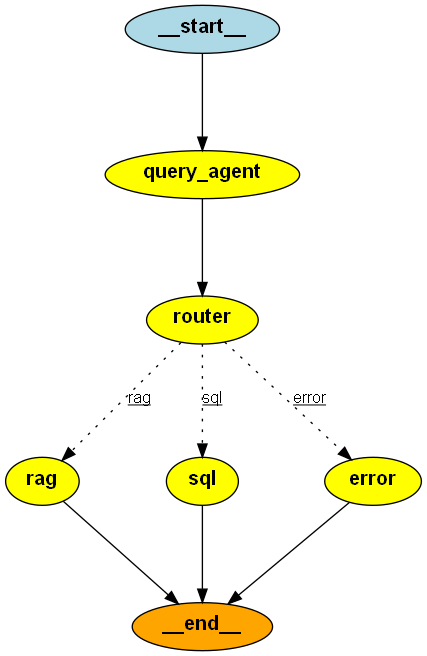

In [52]:
from IPython.display import Image

Image(runnable.get_graph().draw_png())

In [17]:
out = runnable.invoke({"input": "what can you tell me about the relation between consort and rct? `session_id` is abc123"})

> run_query_agent
> router
> execute_search


In [18]:
out["agent_out"]

{'input': 'relation between consort and rct',
 'chat_history': [],
 'context': [Document(page_content='X.-T. Liu et al. CONSORT of RCT in TCM\nendorsement of the CONSORT statement. To strengthen our\nﬁndings, we recommend that this evaluation be expanded to\ninclude more adopter journals in the ﬁeld of TCM. To fa-\ncilitate such a study, we encourage all journals to indicate,\nperhaps in their instructions for authors, whether they support\nthe CONSORT statement and the level of support. Moreover,\nthe sample sizes of two groups of our study were small, such\nthat they may have not enough power to detect the impact\nof adherence to the CONSORT checklist to promote quality\nof reporting. In addition, the RCTs assessed were published\nseveral years ago and may no longer reﬂect current report-\ning practices; the reports of RCTs were extracted from two\njournals and therefore cannot necessarily be generalized to\nfuture studies in the two journals or to a contemporary set of\npapers in ot

In [19]:
out = runnable.invoke({"input": "Tell me more. `session_id` is abc123"})

> run_query_agent
> router
> execute_search


In [20]:
out["agent_out"]

{'input': 'Tell me more',
 'chat_history': [HumanMessage(content='relation between consort and rct'),
  AIMessage(content='The CONSORT statement is a guideline designed to improve the reporting quality of randomized controlled trials (RCTs). It provides a checklist of items that should be included in the report of an RCT to ensure transparency and completeness. Adherence to the CONSORT checklist is believed to enhance the quality of reporting in RCTs by promoting standardized reporting practices.')],
 'context': [],
 'answer': 'The CONSORT (Consolidated Standards of Reporting Trials) statement was first published in 1996 and has since been updated several times to improve the reporting quality of RCTs. The CONSORT checklist includes items related to the title, abstract, introduction, methods, results, and discussion sections of an RCT report. By following the CONSORT guidelines, researchers can ensure that their RCT reports provide clear and comprehensive information about the study de

In [21]:
out = runnable.invoke({"input": "hi. `session_id` is abc123"})

> run_query_agent
> router
> handle_error


In [22]:
out["agent_out"]

'Hello! How can I assist you today?'

In [53]:
out = runnable.invoke({"input": "How many unique titles are there that published in 2021? \n\n `session_id` is abc123"})

> run_query_agent
> router
> execute_sql


In [54]:
out["agent_out"]

'There are 55 unique titles that were published in 2021.'